In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage.interpolation import zoom
from sklearn.metrics import mean_squared_error


fname = 'einstein.jpg'
i_width = 640
i_height = 480

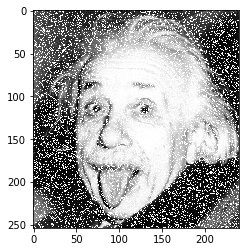

(254, 240)

In [43]:

sampling_threshold = 0.8

image = zoom(np.asarray(Image.open(fname).convert("L")), 0.2).astype(np.float)


image_ss = image.copy()
mask = np.random.uniform(size=image_ss.shape) < 1- sampling_threshold
image_ss[mask] = np.nan
plt.imshow(image_ss, cmap='gray', vmin=0, vmax=255)
plt.show()
image_ss.shape

In [44]:
np.isnan(image_ss[0][1])

False

### a.

Construct ytrain, Xtrain consisting of all available non-N/A pixel values and their positions. Let Xtest be the positions of the missing pixels whose values you are trying to reconstruct.

Next, using each of the following methods:

• RandomForrestRegresor

• GradientBoostingRegressor

• A 2 − D Gaussian kernel feature map regression, where each of your feature maps is φσ(x, x0) = exp(−|x−x0|^2/2σ^2) and you have rescaled your image pixel locations so that x, x0 ∈ [0, 1]2

In [92]:
y_train = []
y_test  = []
X_train = []
X_test  = []
y_test_actual = []


for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if not np.isnan(image_ss[i][j]):
            y_train.append(image_ss[i][j])
            X_train.append([i,j])
        else:
            X_test.append([i,j])
            y_test_actual.append(image[i][j])

In [55]:
def extractDigits(lst):
    return [[el] for el in lst]

In [56]:
y_test_actual = np.array(extractDigits(y_test_actual))
y_test_actual

array([[84.],
       [63.],
       [65.],
       ...,
       [59.],
       [33.],
       [57.]])

12302

### b. and c.

### 1. RandomForestRegressor

In [57]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [58]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()

gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 11),
                                'min_samples_split': range(10, 60, 10)},
                  cv=5,
                  n_jobs=1,
                  scoring='neg_mean_squared_error')

gs.fit(X_train,y_train)

print(gs.best_params_)
print(-gs.best_score_)

{'max_depth': 10, 'min_samples_split': 20}
4418.159874196007


In [59]:
rfModel = RandomForestRegressor(max_depth=10,min_samples_split=20)
rfModel.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [60]:
for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            y = rfModel.predict([[i,j]])
            X_test.append([i,j])
            y_test.append(y)

In [61]:
MSErf = mean_squared_error(y_test,y_test_actual)
MSErf

674.9260644662936

In [62]:
image_ss_complete = np.zeros([254,240])

for i in range(254):
    for j in range(240):
        if [i,j] in X_train:
            pos = X_train.index([i,j])
            image_ss_complete[i][j] = y_train[pos]

        elif [i,j] in X_test:
            pos2 = X_test.index([i,j])
            image_ss_complete[i][j] = y_test[pos2]

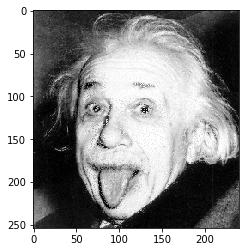

In [63]:
plt.imshow(image_ss_complete, cmap='gray', vmin=0, vmax=255)
plt.show()

### 2. GradientBoostingRegressor

In [64]:
y_test2 = []

model2 = GradientBoostingRegressor()

gs2 = GridSearchCV(model2,
                  param_grid = {'max_depth': [3,5,10],
                                'learning_rate':[0.1,0.3,0.5],
                                'n_estimators':[50,75,100]},
                  cv=5,
                  n_jobs=1,
                  scoring='neg_mean_squared_error')

gs2.fit(X_train,y_train)

print(gs2.best_params_)
print(-gs2.best_score_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
4154.170911663076


In [65]:
gbModel = GradientBoostingRegressor(learning_rate=0.1,max_depth=5,n_estimators=100)
gbModel.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [66]:
X_test2 = []

for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            y = gbModel.predict([[i,j]])
            X_test2.append([i,j])
            y_test2.append(y)

In [67]:
MSEgb = mean_squared_error(y_test2,y_test_actual)
MSEgb

807.2361077570746

In [68]:
image_ss_complete2 = np.zeros([254,240])

for i in range(254):
    for j in range(240):
        if [i,j] in X_train:
            pos = X_train.index([i,j])
            image_ss_complete2[i][j] = y_train[pos]

        elif [i,j] in X_test2:
            pos2 = X_test2.index([i,j])
            image_ss_complete2[i][j] = y_test2[pos2]

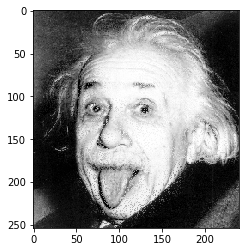

In [69]:
plt.imshow(image_ss_complete2, cmap='gray', vmin=0, vmax=255)
plt.show()

### 3. 2-D Gaussian kernel FM Regressor

In [70]:
from sklearn.model_selection import cross_val_score
from numpy.linalg import norm
from sklearn.linear_model import LinearRegression

In [98]:
X_train_np = np.array(X_train)
X_test_np  = np.array(X_test)
y_train_np = np.array(extractDigits(y_train))

In [99]:
X_train_np

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [253, 236],
       [253, 237],
       [253, 239]])

In [100]:
def gauss(x,x_0,sig):
    return np.exp((-norm(x-x_0)**2) / sig**2) 

In [115]:
x_0  = np.array([125,125]) # roughly in the middle
sigs = [0.25,0.5,0.75,1,2,3,4,5,6,7,8,9,10,15,30,50]
lowestMSE = np.inf

for sig in sigs:
    gauss_X_train = np.array([gauss(x,x_0,sig) for x in X_train_np])
    gauss_X_train = gauss_X_train.reshape((48658,1))
    scores = cross_val_score(LinearRegression(),gauss_X_train,y_train_np,cv=5,scoring='neg_mean_squared_error')
    print(f'sigma = {sig}')
    print(f'MSE = {-scores.mean()}')
    if (-scores.mean() < lowestMSE):
        lowestMSE = -scores.mean()
        

sigma = 0.25
MSE = 9504.965373549849
sigma = 0.5
MSE = 9504.96278395924
sigma = 0.75
MSE = 9504.935933001057
sigma = 1
MSE = inf
sigma = 2
MSE = 4.988033674055313e+125
sigma = 3
MSE = 3.163547226148574e+56
sigma = 4
MSE = 2.820246266433333e+32
sigma = 5
MSE = 2.8633232032913005e+21
sigma = 6
MSE = 3872029897845332.0
sigma = 7
MSE = 1353413061999.9172
sigma = 8
MSE = 8911156102.413242
sigma = 9
MSE = 312207516.31875813
sigma = 10
MSE = 29928598.96471374
sigma = 15
MSE = 140776.89363281996
sigma = 30
MSE = 12702.314638027401
sigma = 50
MSE = 7643.011517213762


In [116]:
lowestMSE

7643.011517213762

In [117]:
lin = LinearRegression()

In [118]:
X_test_np.shape

(12302, 2)

In [119]:
sig = 50

gauss_X_train = np.array([gauss(x,x_0,sig) for x in X_train_np])
gauss_X_train = gauss_X_train.reshape((X_train_np.shape[0],1))

lin.fit(gauss_X_train,y_train_np)

gauss_X_test = np.array([gauss(x,x_0,sig) for x in X_test_np])
gauss_X_test = gauss_X_test.reshape((X_test_np.shape[0],1))

In [120]:
len(y_test_actual)

12302

In [121]:
gauss_y_test = lin.predict(gauss_X_test)
MSE = mean_squared_error(gauss_y_test,y_test_actual)
MSE

5798.050017820173

In [122]:
image_ss_gauss = image_ss.copy()

index = 0
for i in range(0,image_ss_gauss.shape[0]):
    for j in range(0,image_ss_gauss.shape[1]):
        if np.isnan(image_ss_gauss[i][j]):
            image_ss_gauss[i][j] = gauss_y_test[index]
            index += 1

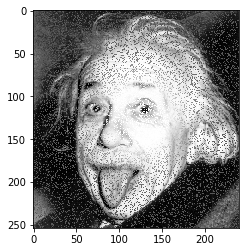

In [123]:
plt.imshow(image_ss_gauss, cmap='gray', vmin=0, vmax=255)
plt.show()

### We can see that the Random Forest Regressor looks like it's performing the best here as it has the lowest MSE. However, Gradient Boosting looks better and  I think this may be due to the inspection of more optimal parameters in the cross-validation stage, allowing the predict function to predict better parameters.

### d. Run these 3 again if it throws an error:

In [92]:
y_train = []
y_test  = []
X_train = []
X_test  = []
y_test_actual = []


for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if not np.isnan(image_ss[i][j]):
            y_train.append(image_ss[i][j])
            X_train.append([i,j])
        else:
            X_test.append([i,j])
            y_test_actual.append(image[i][j])

In [55]:
def extractDigits(lst):
    return [[el] for el in lst]

In [56]:
y_test_actual = np.array(extractDigits(y_test_actual))
y_test_actual

array([[84.],
       [63.],
       [65.],
       ...,
       [59.],
       [33.],
       [57.]])

In [124]:
from sklearn.linear_model import ElasticNet

en = ElasticNet()

In [125]:
X_train_npd = X_train_np
y_train_npd = y_train_np
X_test_npd  = X_test_np

In [127]:
lowestMSE2 = np.inf

for sig in sigs:
    
    gauss_X_train2 = np.array([gauss(x,x_0,sig) for x in X_train_npd])
    gauss_X_train2 = gauss_X_train2.reshape((48658,1))
    scores = cross_val_score(en,gauss_X_train2,y_train_npd,cv=5,scoring='neg_mean_squared_error')
    
    print(f'sigma = {sig}')
    print(f'MSE = {-scores.mean()}')
    if (-scores.mean() < lowestMSE2):
        lowestMSE2 = -scores.mean()
        

sigma = 0.25
MSE = 9504.994772092705
sigma = 0.5
MSE = 9504.994772092705
sigma = 0.75
MSE = 9504.994772092705
sigma = 1
MSE = 9504.994772092705
sigma = 2
MSE = 9504.994772092705
sigma = 3
MSE = 9504.994772092705
sigma = 4
MSE = 9504.994772092705
sigma = 5
MSE = 9504.994772092705
sigma = 6
MSE = 9504.994772092705
sigma = 7
MSE = 9504.994772092705
sigma = 8
MSE = 9504.994772092705
sigma = 9
MSE = 9504.994772092705
sigma = 10
MSE = 9505.01856318883
sigma = 15
MSE = 9504.647596458806
sigma = 30
MSE = 9448.420285694248
sigma = 50
MSE = 8986.996896636269


In [128]:
lowestMSE2

8986.996896636269

### Thus the optimal sigma is 50 out of our choices

In [133]:
sig = 50

gauss_X_train2 = np.array([gauss(x,x_0,sig) for x in X_train_npd])
gauss_X_train2 = gauss_X_train2.reshape((X_train_npd.shape[0],1))

en.fit(gauss_X_train2,y_train_npd)

gauss_X_test2 = np.array([gauss(x,x_0,sig) for x in X_test_npd])
gauss_X_test2 = gauss_X_test2.reshape((X_test_np.shape[0],1))

In [134]:
gauss_y_test2 = lin.predict(gauss_X_test2)
MSE = mean_squared_error(gauss_y_test2,y_test_actual)
MSE

5798.050017820173

In [135]:
image_ss_gauss2 = image_ss.copy()

index = 0
for i in range(0,image_ss_gauss2.shape[0]):
    for j in range(0,image_ss_gauss2.shape[1]):
        if np.isnan(image_ss_gauss2[i][j]):
            image_ss_gauss2[i][j] = gauss_y_test2[index]
            index += 1

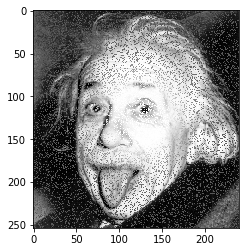

In [136]:
plt.imshow(image_ss_gauss2, cmap='gray', vmin=0, vmax=255)
plt.show()

### e)

In [175]:
X_train_yu = []
X_train_yd = []
X_train_yl = []
X_train_yr = []

X_test_yu = []
X_test_yd = []
X_test_yl = []
X_test_yr = []

X_traini = []
X_trainj = []
X_testi  = []
X_testj  = []

In [176]:
for i in range(0,image_ss.shape[0]):
    for j in range(0,image_ss.shape[1]):
        
        if np.isnan(image_ss[i][j]):
            
            X_testi.append(i)
            X_testj.append(j)
            
            # must have a try here otherwise sometimes it returns errors at the boundaries
            # now if it's out of bounds it will just add -999 anyway
            # up 
            try:
                if i==0:
                    X_test_yu.append(-999)
                    
                elif np.isnan(image_ss[i-1][j]):
                        X_test_yu.append(-999)
                        
                else:
                    X_test_yu.append(image_ss[i-1][j])
                        
            except IndexError as e:
                X_test_yu.append(-999)
                
            # down
            try:
                if i==image_ss.shape[0]:
                    X_test_yd.append(-999)
                    
                elif np.isnan(image_ss[i+1][j]):
                        X_test_yd.append(-999)
                        
                else:
                    X_test_yd.append(image_ss[i+1][j])
                        
            except IndexError as e:
                X_test_yd.append(-999)
            
            # left
            try:
                if j==0:
                    X_test_yl.append(-999)
                    
                elif np.isnan(image_ss[i][j-1]):
                        X_test_yl.append(-999)
                        
                else:
                    X_test_yl.append(image_ss[i][j-1])
                        
            except IndexError as e:
                X_test_yl.append(-999)
                
            # right
            try:
                if j==image_ss.shape[1]:
                    X_test_yr.append(-999)
                    
                elif np.isnan(image_ss[i][j+1]):
                        X_test_yr.append(-999)
                        
                else:
                    X_test_yr.append(image_ss[i][j+1])
                        
            except IndexError as e:
                X_test_yr.append(-999)
                
        else:
            
            X_traini.append(i)
            X_trainj.append(j)
            
            # up 
            try:
                if i==0:
                    X_train_yu.append(-999)
                    
                elif np.isnan(image_ss[i-1][j]):
                        X_train_yu.append(-999)
                        
                else:
                    X_train_yu.append(image_ss[i-1][j])
                        
            except IndexError as e:
                X_train_yu.append(-999)
                
            # down
            try:
                if i==image_ss.shape[0]:
                    X_train_yd.append(-999)
                    
                elif np.isnan(image_ss[i+1][j]):
                        X_train_yd.append(-999)
                        
                else:
                    X_train_yd.append(image_ss[i+1][j])
                        
            except IndexError as e:
                X_train_yd.append(-999)
            
            # left
            try:
                if j==0:
                    X_train_yl.append(-999)
                    
                elif np.isnan(image_ss[i][j-1]):
                        X_train_yl.append(-999)
                        
                else:
                    X_train_yl.append(image_ss[i][j-1])
                        
            except IndexError as e:
                X_train_yl.append(-999)
                
            # right
            try:
                if j==image_ss.shape[1]:
                    X_train_yr.append(-999)
                    
                elif np.isnan(image_ss[i][j+1]):
                        X_train_yr.append(-999)
                        
                else:
                    X_train_yr.append(image_ss[i][j+1])
                        
            except IndexError as e:
                X_train_yr.append(-999)
                
            

97316

In [177]:
import pandas as pd

df1 = pd.DataFrame(zip(X_traini,X_trainj,X_train_yu,X_train_yd,X_train_yl,X_train_yr),columns=['i','j','up','down','left','right'])

df2 = pd.DataFrame(zip(X_testi,X_testj,X_test_yu,X_test_yd,X_test_yl,X_test_yr),columns=['i','j','up','down','left','right'])


In [178]:
df1

,i,j,up,down,left,right
0,0,0,-999.0,103.0,-999.0,89.0
1,0,1,-999.0,90.0,84.0,98.0
2,0,2,-999.0,-999.0,89.0,87.0
3,0,3,-999.0,87.0,98.0,-999.0
4,0,5,-999.0,-999.0,-999.0,82.0
...,...,...,...,...,...,...
48653,253,233,-999.0,-999.0,56.0,31.0
48654,253,234,31.0,-999.0,44.0,-999.0
48655,253,236,32.0,-999.0,-999.0,26.0
48656,253,237,-999.0,-999.0,25.0,-999.0


### RandomForestRegressor with ys:

In [179]:
y_train_np

array([[84.],
       [89.],
       [98.],
       ...,
       [25.],
       [26.],
       [51.]])

In [181]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()

gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 11),
                                'min_samples_split': range(10, 60, 10)},
                  cv=5,
                  n_jobs=1,
                  scoring='neg_mean_squared_error')

gs.fit(df1,y_train_np)

print(gs.best_params_)
print(-gs.best_score_)

{'max_depth': 10, 'min_samples_split': 20}
200.7589363491317


In [182]:
rfModel = RandomForestRegressor(max_depth=10,min_samples_split=20)
rfModel.fit(df1,y_train_np)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [183]:
X_test2 = []
y_test2 = []

In [186]:
y_test2 = rfModel.predict(df2)
MSE = mean_squared_error(y_test_actual,y_test2)
MSE

187.91561207966419

In [188]:
image_ss_complete3 = image_ss.copy()

index = 0
for i in range(image_ss_complete3.shape[0]):
    for j in range(image_ss_complete3.shape[1]):
        if np.isnan(image_ss_complete3[i][j]):
            image_ss_complete3[i][j] = y_test2[index]
            index += 1

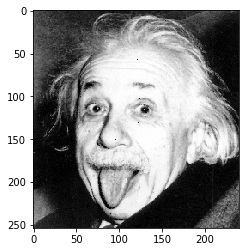

In [189]:
plt.imshow(image_ss_complete3, cmap='gray', vmin=0, vmax=255)
plt.show()

### GradientBoostingRegressor with ys

In [191]:
from sklearn.model_selection import GridSearchCV

model2 = GradientBoostingRegressor()

gs = GridSearchCV(model2,
                  param_grid = {'max_depth': [3,5,10],
                                'learning_rate':[0.1,0.3,0.5],
                                'n_estimators':[50,75,100]},
                  cv=5,
                  n_jobs=1,
                  scoring='neg_mean_squared_error')

gs.fit(df1,y_train_np)

print(gs.best_params_)
print(-gs.best_score_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
181.12659547528474


In [193]:
gbModel = GradientBoostingRegressor(max_depth=5,learning_rate=0.1,n_estimators=100)
gbModel.fit(df1,y_train_np)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [194]:
X_test3 = []
y_test3 = []

In [195]:
y_test3 = gbModel.predict(df2)
MSE = mean_squared_error(y_test_actual,y_test3)
MSE

161.93799834274037

In [196]:
image_ss_complete4 = image_ss.copy()

index = 0
for i in range(image_ss_complete4.shape[0]):
    for j in range(image_ss_complete4.shape[1]):
        if np.isnan(image_ss_complete4[i][j]):
            image_ss_complete4[i][j] = y_test3[index]
            index += 1

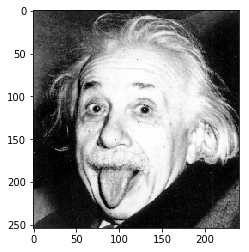

In [197]:
plt.imshow(image_ss_complete4, cmap='gray', vmin=0, vmax=255)
plt.show()

### 2-D Gaussian Kernel FM Regressor with ys

In [199]:
X_train_npd2 = df1.to_numpy()
X_test_npd2  = df2.to_numpy()

In [205]:
48658/2

24329.0

In [206]:
lowestMSE3 = np.inf

x_0 = X_train_npd2[24329]

for sig in sigs:
    
    gauss_X_train3 = np.array([gauss(x,x_0,sig) for x in X_train_npd2])
    gauss_X_train3 = gauss_X_train3.reshape((X_train_npd2.shape[0],1))
    scores = cross_val_score(en,gauss_X_train3,y_train_npd,cv=5,scoring='neg_mean_squared_error')
    
    print(f'sigma = {sig}')
    print(f'MSE = {-scores.mean()}')
    if (-scores.mean() < lowestMSE3):
        lowestMSE3 = -scores.mean()

sigma = 0.25
MSE = 9504.994772092705
sigma = 0.5
MSE = 9504.994772092705
sigma = 0.75
MSE = 9504.994772092705
sigma = 1
MSE = 9504.994772092705
sigma = 2
MSE = 9504.994772092705
sigma = 3
MSE = 9504.994772092705
sigma = 4
MSE = 9504.994772092705
sigma = 5
MSE = 9504.994772092705
sigma = 6
MSE = 9504.994772092705
sigma = 7
MSE = 9504.994772092705
sigma = 8
MSE = 9504.994772092705
sigma = 9
MSE = 9504.994772092705
sigma = 10
MSE = 9504.994772092705
sigma = 15
MSE = 9504.994772092705
sigma = 30
MSE = 9505.071274484731
sigma = 50
MSE = 9504.542102155796


In [207]:
lowestMSE3

9504.542102155796

Thus choose sigma = 50

In [208]:
sig = 50

gauss_X_train3 = np.array([gauss(x,x_0,sig) for x in X_train_npd2])
gauss_X_train3 = gauss_X_train3.reshape((X_train_npd2.shape[0],1))

en.fit(gauss_X_train3,y_train_npd)

gauss_X_test3 = np.array([gauss(x,x_0,sig) for x in X_test_npd2])
gauss_X_test3 = gauss_X_test3.reshape((X_test_npd2.shape[0],1))

In [209]:
gauss_y_test3 = lin.predict(gauss_X_test3)
MSE = mean_squared_error(gauss_y_test3,y_test_actual)
MSE

10771.21111500808

In [210]:
image_ss_gauss2 = image_ss.copy()

index = 0
for i in range(image_ss_gauss2.shape[0]):
    for j in range(image_ss_gauss2.shape[1]):
        if np.isnan(image_ss_gauss2[i][j]):
            image_ss_gauss2[i][j] = gauss_y_test3[index]
            index += 1

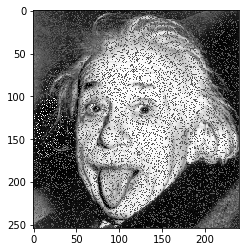

In [211]:
plt.imshow(image_ss_gauss2, cmap='gray', vmin=0, vmax=255)
plt.show()

### Thus the GradientBoostingRegressor produces the lowest MSE with a value of 161.94